#**Background Removal**


In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path

def remove_background(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # === Step 1: Define Full-Range Masks ===
    masks = []

    # 🟢 Green: Full green hue range
    masks.append(cv2.inRange(hsv, np.array([25, 30, 30]), np.array([100, 255, 255])))

    # 🟡 Yellow: Full yellow range including pale yellow
    masks.append(cv2.inRange(hsv, np.array([15, 10, 10]), np.array([40, 255, 255])))

    # 🔴 Red: Red wraps around, so use two ranges
    red1 = cv2.inRange(hsv, np.array([0, 40, 20]), np.array([10, 255, 255]))   # Lower reds
    red2 = cv2.inRange(hsv, np.array([160, 40, 20]), np.array([180, 255, 255])) # Upper reds
    masks.append(cv2.bitwise_or(red1, red2))

    # 🟣 Purple/Magenta: Full range from deep magenta to violet
    masks.append(cv2.inRange(hsv, np.array([110, 30, 20]), np.array([170, 255, 255])))

    # Combine all color masks
    leaf_mask = masks[0]
    for m in masks[1:]:
        leaf_mask = cv2.bitwise_or(leaf_mask, m)

    # === Step 2: Remove white/light gray background ===
    white_bg_mask = cv2.inRange(hsv, np.array([0, 0, 200]), np.array([180, 40, 255]))
    non_white_mask = cv2.bitwise_not(white_bg_mask)

    # === Step 3: Combine color + non-white background ===
    combined_mask = cv2.bitwise_and(leaf_mask, non_white_mask)

    # === Step 4: Apply the mask ===
    leaf_only = cv2.bitwise_and(image, image, mask=combined_mask)

    # === Step 5: Replace background with black ===
    black_bg = np.zeros_like(image)
    final_result = np.where(combined_mask[:, :, None] == 0, black_bg, leaf_only)

    return final_result


def process_dataset(input_root, output_root):
    input_root = Path(input_root)
    output_root = Path(output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    for category_folder in input_root.glob("*"):
        if category_folder.is_dir():
            out_folder = output_root / category_folder.name
            out_folder.mkdir(parents=True, exist_ok=True)

            for img_path in category_folder.glob("*.*"):
                if img_path.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
                    continue

                image = cv2.imread(str(img_path))
                if image is None:
                    continue

                cleaned = remove_background(image)

                output_path = out_folder / img_path.name
                cv2.imwrite(str(output_path), cleaned)
                print(f"[✔] Processed: {img_path.name} -> {output_path}")


# === Example Usage ===
if __name__ == "__main__":
    input_dataset_path = "/content/drive/MyDrive/cotton"
    output_dataset_path = "/content/drive/MyDrive/cotton-leaf-disease-cleaned-black-bg-full-range"
    process_dataset(input_dataset_path, output_dataset_path)


# **Normalizing**

In [ ]:
import os
import cv2

# Define base paths
input_base = "/content/drive/MyDrive/cotton-leaf-disease-cleaned"
output_base = "/content/drive/MyDrive/normalized-cotton-leaf-disease"

# Create output base directory if it doesn't exist
os.makedirs(output_base, exist_ok=True)

# Loop through all subfolders and files
for root, dirs, files in os.walk(input_base):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            input_path = os.path.join(root, file)
            try:
                # Read and normalize image
                img = cv2.imread(input_path)
                img_normalized = img.astype("float32") / 255.0

                # Create corresponding output path
                relative_path = os.path.relpath(root, input_base)
                output_dir = os.path.join(output_base, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, (img_normalized * 255).astype("uint8"))

            except Exception as e:
                print(f"Error processing {input_path}: {e}")


# **ClACHE** - CLAHE is used to enhance local contrast in images, making disease symptoms more visible — especially helpful in plant pathology images with uneven lighting or subtle symptoms.


<ipython-input-8-ff36d2da9942>:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),


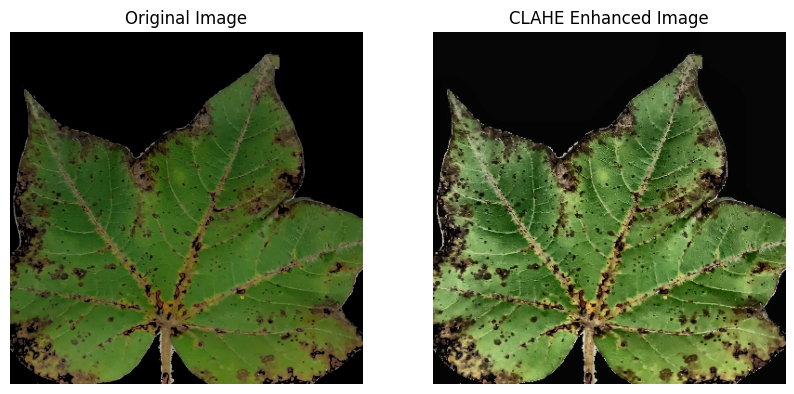

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 380

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),  # << CLAHE Added here
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.GridDistortion(p=0.3),
    A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),  # Always apply CLAHE during testing
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

import matplotlib.pyplot as plt

image = cv2.imread("/content/BBC00232.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

clahe_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0)
])

processed = clahe_transform(image=image)["image"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed)
plt.title("CLACHE Enhanced Image")
plt.axis("off")
plt.show()



# **Enhancing Required colors**

In [ ]:
import cv2
import numpy as np
import os
from google.colab import drive

# ------------------------------
# 1️⃣ Mount Google Drive
# ------------------------------

# Define input and output base directories
INPUT_FOLDER = "/content/drive/MyDrive/normalized-cotton-leaf-disease"
OUTPUT_FOLDER = "/content/drive/MyDrive/Enhanced-cotton-leaf-disease"

# ------------------------------
# 2️⃣ Function to Enhance N, P, K Colors
# ------------------------------
def enhance_leaf_colors(image):
    """Enhance yellow-green, purple, and reddish-brown (NPK deficiency colors)."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    color_ranges = {
        "N": [(25, 40, 40), (35, 255, 255)],    # Yellowish-Green
        "P": [(125, 40, 40), (160, 255, 255)],  # Purplish
        "K": [(5, 40, 40), (20, 255, 255)]      # Reddish-Brown
    }

    for key, (lower, upper) in color_ranges.items():
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        hsv[:, :, 1] = cv2.add(hsv[:, :, 1], mask // 4)  # Boost saturation
        hsv[:, :, 2] = cv2.add(hsv[:, :, 2], mask // 4)  # Boost brightness

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# ------------------------------
# 3️⃣ Enhance All Images Recursively
# ------------------------------
for root, dirs, files in os.walk(INPUT_FOLDER):
    for filename in files:
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            input_path = os.path.join(root, filename)

            try:
                image = cv2.imread(input_path)
                enhanced_image = enhance_leaf_colors(image)

                # Preserve subfolder structure
                relative_path = os.path.relpath(root, INPUT_FOLDER)
                output_dir = os.path.join(OUTPUT_FOLDER, relative_path)
                os.makedirs(output_dir, exist_ok=True)

                output_path = os.path.join(output_dir, f"enhanced_{filename}")
                cv2.imwrite(output_path, enhanced_image)

                print(f"✅ Enhanced & saved: {output_path}")

            except Exception as e:
                print(f"❌ Error processing {input_path}: {e}")

print("\n🚀 Color Enhancement Complete! All enhanced images saved to:", OUTPUT_FOLDER)


✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00007.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00003.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00006.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00005.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00009.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00004.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00011.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00008.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus/enhanced_CV00010.jpg
✅ Enhanced & saved: /content/drive/MyDrive/Enhanced-cotton-leaf-

# **Percentage Generation**

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os

def calculate_color_percentage(image_path):
    """
    Calculate the percentage of specified color areas (green, yellow,
    purplish and brown-red) with respect to the leaf area in the image.
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error reading image: {image_path}")
        return None

    # Convert image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define thresholds for colors in the HSV color space
    lower_dark_green = np.array([35, 50, 50])
    upper_dark_green = np.array([85, 255, 255])

    lower_light_green = np.array([85, 50, 50])
    upper_light_green = np.array([95, 255, 255])

    lower_yellow = np.array([25, 40, 40])
    upper_yellow = np.array([40, 255, 255])

    lower_purplish = np.array([125, 40, 40])
    upper_purplish = np.array([190, 255, 255])

    lower_brown_red = np.array([5, 40, 40])
    upper_brown_red = np.array([30, 255, 255])

    # Create masks for each color region
    mask_dark_green = cv2.inRange(hsv_image, lower_dark_green, upper_dark_green)
    mask_light_green = cv2.inRange(hsv_image, lower_light_green, upper_light_green)
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    mask_purplish = cv2.inRange(hsv_image, lower_purplish, upper_purplish)
    mask_brown_red = cv2.inRange(hsv_image, lower_brown_red, upper_brown_red)

    # Combine green masks for dark & light green
    mask_green = cv2.bitwise_or(mask_dark_green, mask_light_green)

    # Calculate area (number of non-zero pixels) for each mask
    green_area = np.count_nonzero(mask_green)
    yellow_area = np.count_nonzero(mask_yellow)
    purplish_area = np.count_nonzero(mask_purplish)
    brown_red_area = np.count_nonzero(mask_brown_red)

    # Define total leaf area using grayscale conversion
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    leaf_area = np.count_nonzero(gray_image)  # all non-black pixels

    # Avoid division by zero
    if leaf_area == 0:
        return 0, 0, 0, 0

    # Calculate and return the percentages, rounding to 4 decimals
    # Here we treat: yellow as nitrogen deficiency (n_def),
    # purplish as phosphorus deficiency (p_def), and brown-red as potassium deficiency (k_def)
    green_percentage = round((green_area / leaf_area) * 100, 4)
    yellow_percentage = round((yellow_area / leaf_area) * 100, 4)
    purplish_percentage = round((purplish_area / leaf_area) * 100, 4)
    brown_red_percentage = round((brown_red_area / leaf_area) * 100, 4)

    return green_percentage, yellow_percentage, purplish_percentage, brown_red_percentage

def analyze_images_in_folder(folder_path, output_csv):
    """
    Analyze images in the given folder, calculate color percentages and save results to a CSV.
    The CSV file includes filename, yellow (n_def), purplish (p_def), and brown-red (k_def) percentages.
    """
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            percentages = calculate_color_percentage(image_path)
            if percentages is not None:
                green_percentage, yellow_percentage, purplish_percentage, brown_red_percentage = percentages
                # In the CSV: we report yellow as n_def, purplish as p_def, and brown-red as k_def.
                results.append((filename, yellow_percentage, purplish_percentage, brown_red_percentage))

    # Create a DataFrame and save to CSV.
    # Columns: 'img', 'n_def', 'p_def', 'k_def'
    df_results = pd.DataFrame(results, columns=["img", "n_def", "p_def", "k_def"])
    df_results.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

# ------------------------------
# Define the dataset and output paths
# ------------------------------
# Path to the main dataset folder where each subfolder represents a class.
DATASET_FOLDER = "/content/drive/MyDrive/Enhanced-cotton-leaf-disease"

# Output folder for CSV files
OUTPUT_CSV_FOLDER = "/content/drive/MyDrive/CSV_Results"

# Create the output folder if it doesn't exist.
if not os.path.exists(OUTPUT_CSV_FOLDER):
    os.makedirs(OUTPUT_CSV_FOLDER)

# Loop through each class (subfolder) in the dataset and generate a separate CSV file
for class_folder in os.listdir(DATASET_FOLDER):
    class_folder_path = os.path.join(DATASET_FOLDER, class_folder)
    if os.path.isdir(class_folder_path):
        output_csv = os.path.join(OUTPUT_CSV_FOLDER, f"{class_folder}_results.csv")
        print(f"Analyzing {class_folder_path} ...")
        analyze_images_in_folder(class_folder_path, output_csv)

print("\n🚀 Analysis Complete! CSV results are stored in:", OUTPUT_CSV_FOLDER)


Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Curl Virus ...
Results saved to /content/drive/MyDrive/CSV_Results/Curl Virus_results.csv
Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Leaf Variegation ...
Results saved to /content/drive/MyDrive/CSV_Results/Leaf Variegation_results.csv
Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Leaf Hopper Jassids ...
Results saved to /content/drive/MyDrive/CSV_Results/Leaf Hopper Jassids_results.csv
Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Healthy Leaf ...
Results saved to /content/drive/MyDrive/CSV_Results/Healthy Leaf_results.csv
Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Bacterial Blight ...
Results saved to /content/drive/MyDrive/CSV_Results/Bacterial Blight_results.csv
Analyzing /content/drive/MyDrive/Enhanced-cotton-leaf-disease/Leaf Redding ...
Results saved to /content/drive/MyDrive/CSV_Results/Leaf Redding_results.csv
Analyzing /content/drive/MyDrive/Enhan

#**Distribution Plots**

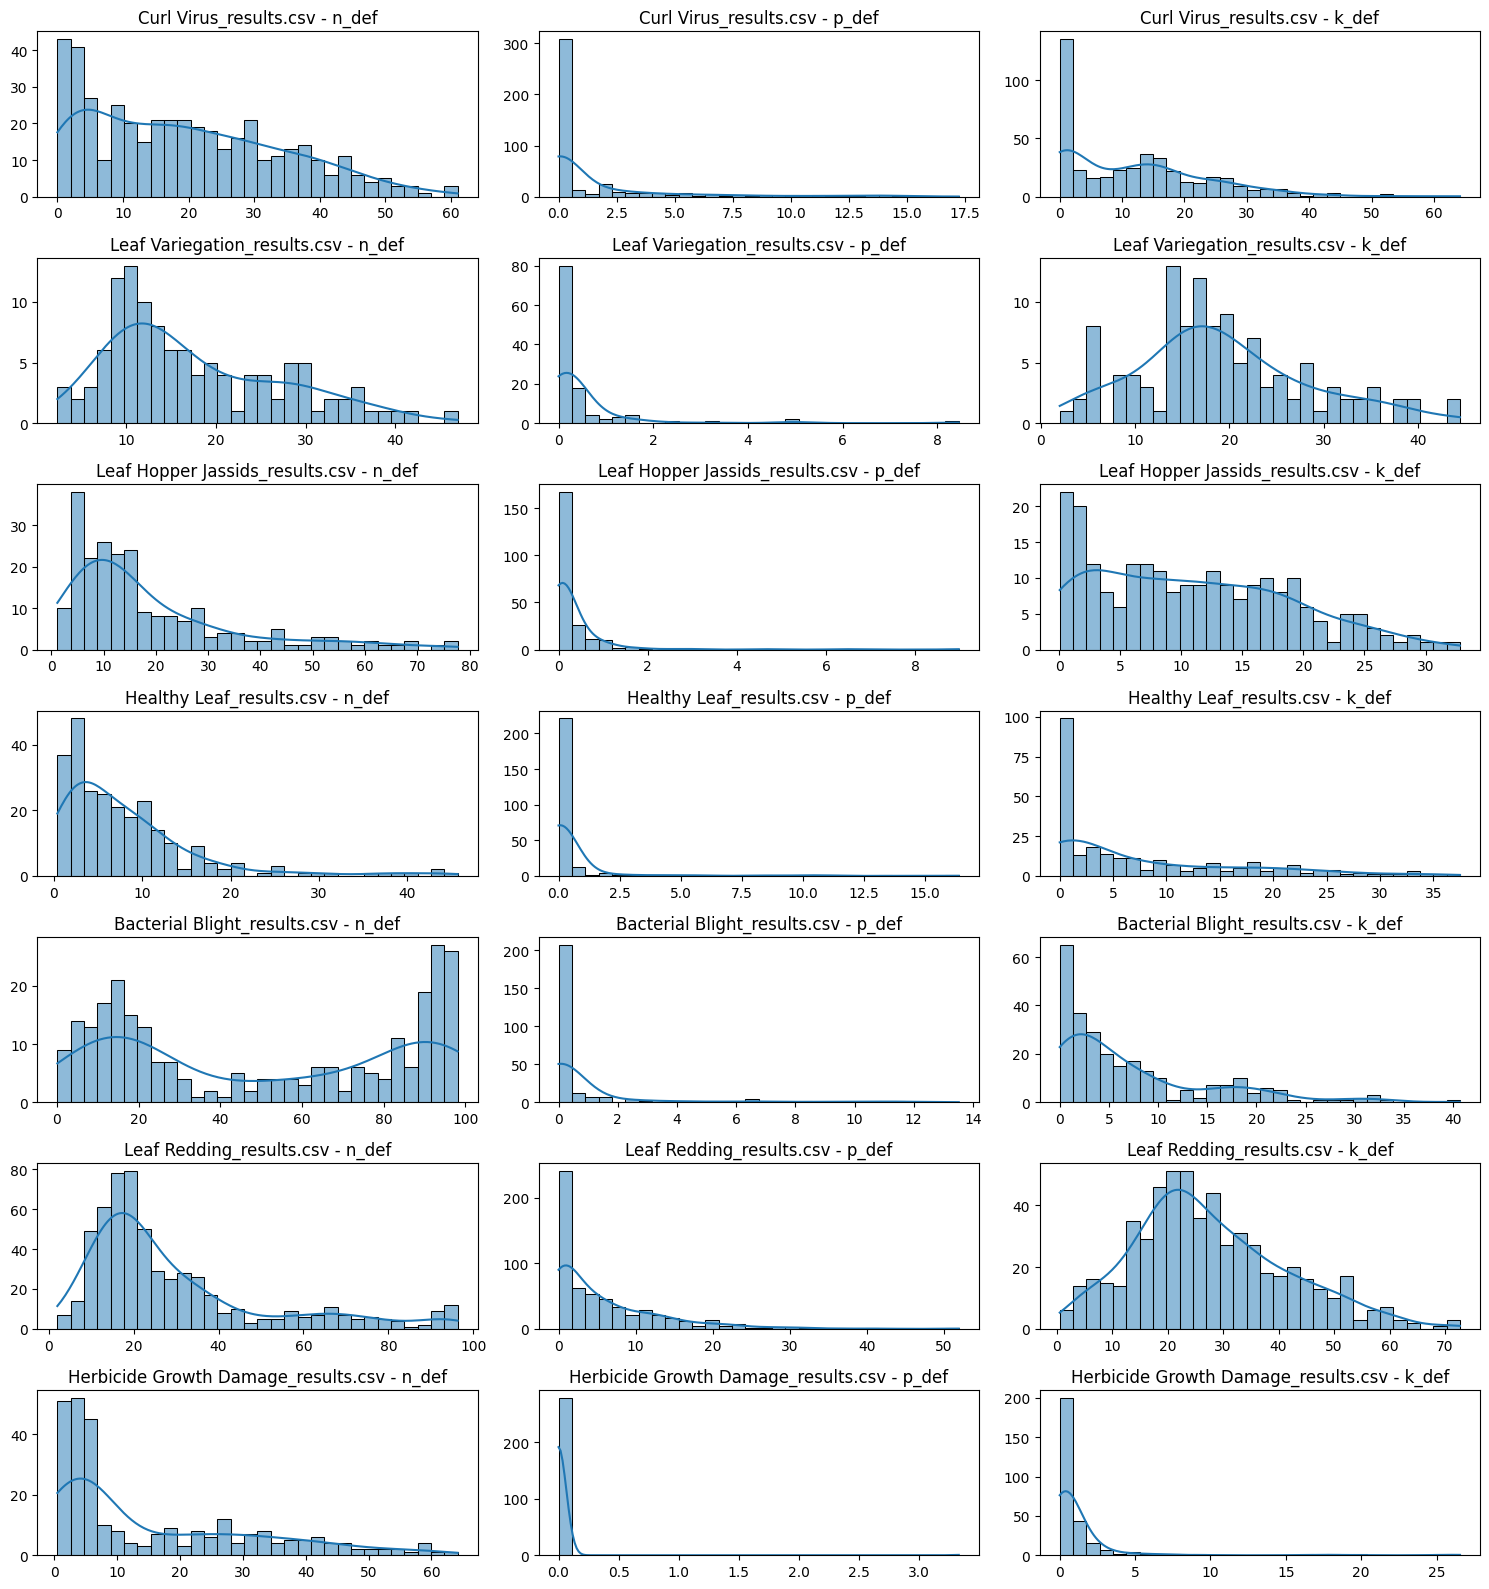

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === List of file paths ===
csv_files = [
    "/content/drive/MyDrive/CSV_Results/Curl Virus_results.csv",
    "/content/drive/MyDrive/CSV_Results/Leaf Variegation_results.csv",
    "/content/drive/MyDrive/CSV_Results/Leaf Hopper Jassids_results.csv",
    "/content/drive/MyDrive/CSV_Results/Healthy Leaf_results.csv",
    "/content/drive/MyDrive/CSV_Results/Bacterial Blight_results.csv",
    "/content/drive/MyDrive/CSV_Results/Leaf Redding_results.csv",
    "/content/drive/MyDrive/CSV_Results/Herbicide Growth Damage_results.csv"
]

# === Numerical columns to plot ===
num_cols = ['n_def', 'p_def', 'k_def']

# === Setup figure ===
plt.figure(figsize=(15, 16))

for row_idx, file_path in enumerate(csv_files):
    df = pd.read_csv(file_path)
    file_name = file_path.split("/")[-1]  # Get just the filename for title

    for col_idx, col in enumerate(num_cols):
        plt.subplot(len(csv_files), len(num_cols), row_idx * len(num_cols) + col_idx + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'{file_name} - {col}')
        plt.xlabel('')
        plt.ylabel('')

plt.tight_layout()
plt.show()


#**Classification Model**


Found 1723 images belonging to 7 classes.
Found 428 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 112s 795ms/step - accuracy: 0.2895 - loss: 2.5384 - val_accuracy: 0.4813 - val_loss: 1.6788
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 463ms/step - accuracy: 0.4546 - loss: 1.6882 - val_accuracy: 0.5187 - val_loss: 1.5836
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 50s 466ms/step - accuracy: 0.5202 - loss: 1.4692 - val_accuracy: 0.5771 - val_loss: 1.3636
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 472ms/step - accuracy: 0.5705 - loss: 1.3296 - val_accuracy: 0.6028 - val_loss: 1.4522
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 472ms/step - accuracy: 0.6024 - loss: 1.2576 - val_accuracy: 0.5654 - val_loss: 1.4903
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 471ms/step - accuracy: 0.5852 - loss: 1.2748 - val_accuracy: 0.5958 - val_loss: 1.4134
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 477ms/step - accuracy: 0.6379 - loss: 1.1987 - val_accuracy: 0.6098 - val_loss: 1.4454
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 476ms/step - accuracy: 0.6203 - loss: 

108/108 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5556 - loss: 1.5137 - val_accuracy: 0.6495 - val_loss: 1.2568 - learning_rate: 1.0000e-05
Epoch 11/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6172 - loss: 1.2422
Epoch 11: val_accuracy improved from 0.64953 to 0.67757, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 0.6173 - loss: 1.2419 - val_accuracy: 0.6776 - val_loss: 1.1382 - learning_rate: 1.0000e-05
Epoch 12/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6842 - loss: 1.0812
Epoch 12: val_accuracy did not improve from 0.67757
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 485ms/step - accuracy: 0.6841 - loss: 1.0812 - val_accuracy: 0.6355 - val_loss: 1.2016 - learning_rate: 1.0000e-05
Epoch 13/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.6876 - loss: 1.0333
Epoch 13: val_accuracy improved from 0.67757 to 0.68458, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 502ms/step - accuracy: 0.6877 - loss: 1.0333 - val_accuracy: 0.6846 - val_loss: 1.1112 - learning_rate: 1.0000e-05
Epoch 14/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7091 - loss: 0.9619
Epoch 14: val_accuracy improved from 0.68458 to 0.71028, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 81s 494ms/step - accuracy: 0.7092 - loss: 0.9617 - val_accuracy: 0.7103 - val_loss: 1.0863 - learning_rate: 1.0000e-05
Epoch 15/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.7412 - loss: 0.8731
Epoch 15: val_accuracy improved from 0.71028 to 0.71963, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 56s 515ms/step - accuracy: 0.7411 - loss: 0.8734 - val_accuracy: 0.7196 - val_loss: 1.0212 - learning_rate: 1.0000e-05
Epoch 16/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.7255 - loss: 0.9151
Epoch 16: val_accuracy did not improve from 0.71963
108/108 ━━━━━━━━━━━━━━━━━━━━ 53s 493ms/step - accuracy: 0.7256 - loss: 0.9147 - val_accuracy: 0.7103 - val_loss: 1.0553 - learning_rate: 1.0000e-05
Epoch 17/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7503 - loss: 0.8375
Epoch 17: val_accuracy did not improve from 0.71963
108/108 ━━━━━━━━━━━━━━━━━━━━ 52s 479ms/step - accuracy: 0.7502 - loss: 0.8376 - val_accuracy: 0.7173 - val_loss: 1.0386 - learning_rate: 1.0000e-05
Epoch 18/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.7495 - loss: 0.8064
Epoch 18: val_accuracy improved from 0.71963 to 0.74766, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 496ms/step - accuracy: 0.7495 - loss: 0.8063 - val_accuracy: 0.7477 - val_loss: 0.9949 - learning_rate: 1.0000e-05
Epoch 19/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7620 - loss: 0.7837
Epoch 19: val_accuracy did not improve from 0.74766
108/108 ━━━━━━━━━━━━━━━━━━━━ 80s 482ms/step - accuracy: 0.7622 - loss: 0.7835 - val_accuracy: 0.7407 - val_loss: 0.9837 - learning_rate: 1.0000e-05
Epoch 20/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7719 - loss: 0.7629
Epoch 20: val_accuracy improved from 0.74766 to 0.76402, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 54s 498ms/step - accuracy: 0.7719 - loss: 0.7629 - val_accuracy: 0.7640 - val_loss: 0.9974 - learning_rate: 1.0000e-05
Epoch 21/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7690 - loss: 0.7526
Epoch 21: val_accuracy did not improve from 0.76402
108/108 ━━━━━━━━━━━━━━━━━━━━ 80s 478ms/step - accuracy: 0.7692 - loss: 0.7524 - val_accuracy: 0.7243 - val_loss: 0.9761 - learning_rate: 1.0000e-05
Epoch 22/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.7840 - loss: 0.7063
Epoch 22: val_accuracy improved from 0.76402 to 0.76869, saving model to /content/drive/MyDrive/best_densenet_model_improved.h5


108/108 ━━━━━━━━━━━━━━━━━━━━ 55s 506ms/step - accuracy: 0.7841 - loss: 0.7063 - val_accuracy: 0.7687 - val_loss: 0.9292 - learning_rate: 1.0000e-05
Epoch 23/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8241 - loss: 0.6466
Epoch 23: val_accuracy did not improve from 0.76869
108/108 ━━━━━━━━━━━━━━━━━━━━ 79s 481ms/step - accuracy: 0.8240 - loss: 0.6468 - val_accuracy: 0.7593 - val_loss: 1.0114 - learning_rate: 1.0000e-05
Epoch 24/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.8100 - loss: 0.6677
Epoch 24: val_accuracy did not improve from 0.76869
108/108 ━━━━━━━━━━━━━━━━━━━━ 51s 477ms/step - accuracy: 0.8100 - loss: 0.6678 - val_accuracy: 0.7523 - val_loss: 0.9366 - learning_rate: 1.0000e-05
Epoch 25/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8085 - loss: 0.7100
Epoch 25: val_accuracy did not improve from 0.76869

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy

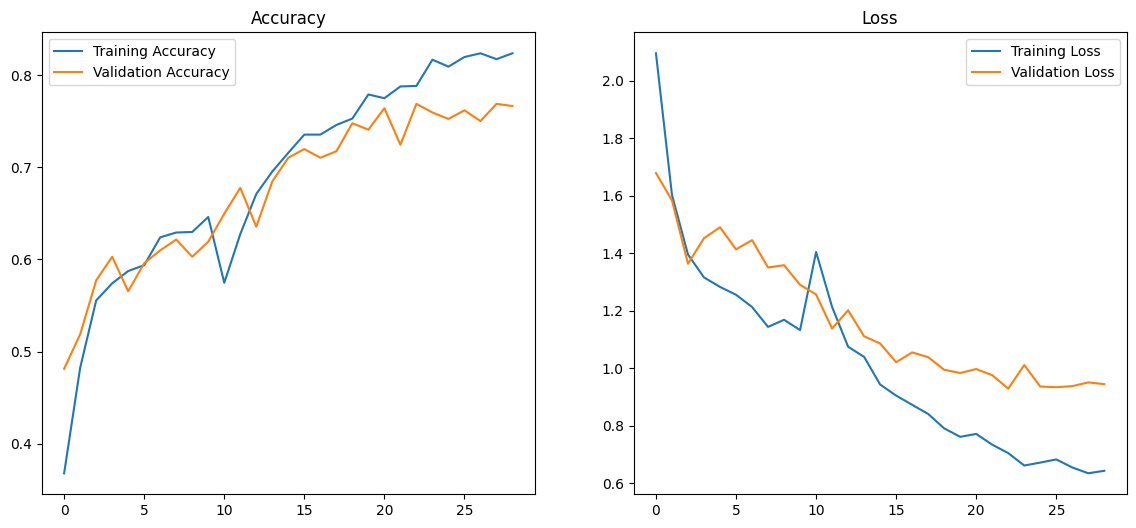

27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step


<Figure size 1000x800 with 0 Axes>

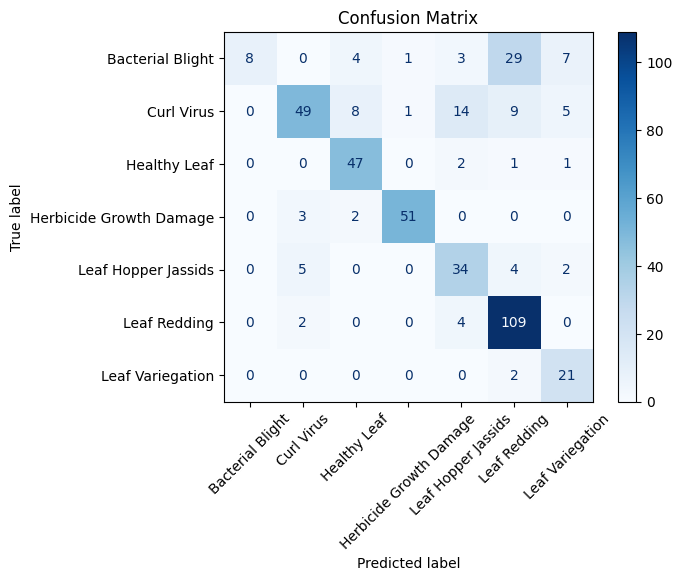

Classification Report:

                         precision    recall  f1-score   support

       Bacterial Blight       1.00      0.15      0.27        52
             Curl Virus       0.83      0.57      0.68        86
           Healthy Leaf       0.77      0.92      0.84        51
Herbicide Growth Damage       0.96      0.91      0.94        56
    Leaf Hopper Jassids       0.60      0.76      0.67        45
           Leaf Redding       0.71      0.95      0.81       115
       Leaf Variegation       0.58      0.91      0.71        23

               accuracy                           0.75       428
              macro avg       0.78      0.74      0.70       428
           weighted avg       0.79      0.75      0.72       428

✅ Final Validation Accuracy: 74.53%


In [ ]:


# ✅ Step 2: Set dataset path
dataset_path = '/content/drive/MyDrive/cotton-leaf-disease-cleaned'

# ✅ Step 3: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ✅ Step 4: Prepare Data Generators with stronger augmentation
IMAGE_SIZE = 256
BATCH_SIZE = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    zoom_range=0.4,
    shear_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())

# ✅ Step 5: Build Model with DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Step 6: Initial Training
initial_epochs = 10
history = model.fit(
    train_data,
    epochs=initial_epochs,
    validation_data=val_data
)

# ✅ Step 7: Fine-Tuning
base_model.trainable = True
fine_tune_at = 200  # Unfreeze top 100 layers or so
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = '/content/drive/MyDrive/best_densenet_model_improved.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)
]

fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_data,
    epochs=total_epochs,
    validation_data=val_data,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

# ✅ Step 8: Plot Accuracy & Loss
def plot_metrics(hist1, hist2):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_metrics(history, history_fine)

# ✅ Step 9: Confusion Matrix & Final Accuracy
val_data.reset()
Y_pred = model.predict(val_data, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_data.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report + Final Accuracy
from sklearn.metrics import accuracy_score
final_acc = accuracy_score(y_true, y_pred)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
print(f"✅ Final Validation Accuracy: {final_acc * 100:.2f}%")


#**Efficient-Net- B4 - 96% accuracy**

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# 1. Dataset Directory Setup
# ---------------------------
data_dir = "/kaggle/input/cotton-leaf/Enhanced-cotton-leaf-disease"

# ---------------------------
# 2. Image & Label Extraction
# ---------------------------
def get_image_paths_and_labels(root_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(root_dir))
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(root_dir, class_name)
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(label)
    return image_paths, labels, class_names

image_paths, labels, classes = get_image_paths_and_labels(data_dir)
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# ---------------------------
# 3. Data Augmentations
# ---------------------------
IMG_SIZE = 380
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.GridDistortion(p=0.3),
    A.CLAHE(p=0.2),
    A.CoarseDropout(max_holes=1, max_height=30, max_width=30, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# ---------------------------
# 4. Dataset Class
# ---------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        image = self.transform(image=image)["image"]
        return image, label

# ---------------------------
# 5. Weighted Sampler
# ---------------------------
def get_weighted_sampler(labels):
    class_counts = np.bincount(labels)
    class_weights = 1. / np.maximum(class_counts, 1)
    weights = [class_weights[label] for label in labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

# ---------------------------
# 6. Model Definition
# ---------------------------
def get_model(num_classes):
    model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 1024),
        nn.ReLU(),
        nn.LayerNorm(1024),
        nn.Dropout(0.4),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.LayerNorm(512),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    return model.to(device)

# ---------------------------
# 7. Label Smoothing Loss
# ---------------------------
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.05):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        n_classes = preds.size(1)
        log_preds = F.log_softmax(preds, dim=-1)
        targets = F.one_hot(targets, n_classes).float()
        targets = targets * (1 - self.smoothing) + self.smoothing / n_classes
        return torch.mean(torch.sum(-targets * log_preds, dim=-1))

# ---------------------------
# 8. Optimizer and Scheduler
# ---------------------------
def get_optimizer(model, num_epochs=70):
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    return optimizer, scheduler

# ---------------------------
# 9. Training Function
# ---------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70, patience=10):
    scaler = torch.cuda.amp.GradScaler()
    history = {"train_loss": [], "val_acc": []}
    best_acc, counter = 0, 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        val_acc = evaluate_model(model, val_loader, show_cm=False)
        history["train_loss"].append(running_loss / total)
        history["val_acc"].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!")
                break

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/total:.4f}, Val Acc: {val_acc:.2f}%")

    return model, history

# ---------------------------
# 10. Evaluation Function
# ---------------------------
def evaluate_model(model, loader, show_cm=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))

    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    return accuracy

# ---------------------------
# 11. Main Training Script
# ---------------------------
if __name__ == "__main__":
    train_loader = DataLoader(
        CustomDataset(train_images, train_labels, train_transform),
        batch_size=16,
        sampler=get_weighted_sampler(train_labels),
        num_workers=2,
        drop_last=True
    )

    val_loader = DataLoader(
        CustomDataset(val_images, val_labels, test_transform),
        batch_size=16,
        shuffle=False,
        num_workers=2
    )

    model = get_model(len(classes))
    optimizer, scheduler = get_optimizer(model)
    model, history = train_model(model, train_loader, val_loader, LabelSmoothingLoss(), optimizer, scheduler)

    print("\nFinal Evaluation on Validation Set:")
    final_acc = evaluate_model(model, val_loader, show_cm=True)
    print(f"Final Validation Accuracy: {final_acc:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss", color="blue", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["val_acc"], label="Validation Accuracy", color="green", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import cv2
import torch
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

# Define class names (from confusion matrix)
class_names = [
    "Bacterial Blight",
    "Curl Virus",
    "Healthy Leaf",
    "Herbicide Growth Damage",
    "Leaf Hopper Jassids",
    "Leaf Redding",
    "Leaf Variegation"
]

# Image transform
test_transform = A.Compose([
    A.Resize(380, 380),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1024),
    torch.nn.ReLU(),
    torch.nn.LayerNorm(1024),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.LayerNorm(512),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, len(class_names))
)
model.load_state_dict(torch.load("/content/drive/MyDrive/best_model.pth", map_location=device))
model.to(device)
model.eval()

# Prediction function
def predict_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found or unable to read: {image_path}")

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = test_transform(image=image_rgb)["image"]
    transformed = transformed.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(transformed)
        pred = outputs.argmax(dim=1).item()
        confidence = torch.softmax(outputs, dim=1)[0, pred].item()

    return class_names[pred], confidence


# Example usage
image_path = "/content/BBC00232.jpg"  # Change this to your image
predicted_class, confidence = predict_image(image_path)
print(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")


Predicted: Bacterial Blight (86.81%)


# **Prediction model**

📸 Total Images: 2151


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - loss: 225.4036 - mae: 9.4801 - mse: 223.7953 - val_loss: 279.1839 - val_mae: 9.8262 - val_mse: 277.5625 - learning_rate: 3.0000e-04
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 98.5157 - mae: 6.7523 - mse: 96.8931 - val_loss: 251.9785 - val_mae: 9.4336 - val_mse: 250.3515 - learning_rate: 3.0000e-04
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 77.2326 - mae: 6.0473 - mse: 75.6042 - val_loss: 243.4707 - val_mae: 10.8407 - val_mse: 241.8378 - learning_rate: 3.0000e-04
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 67.9736 - mae: 5.5089 - mse: 66.3395 - val_loss: 182.5278 - val_mae: 9.5044 - val_mse: 180.8890 - learning_rate: 3.0000e-04
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 64.7476 - mae: 5.4454 - mse: 63.1076 - val_loss: 115.4373 - val_mae: 6.9509 - val_mse: 113.7943 - learning_rate: 3.0000e-04
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 56.7136 - mae: 5


✅ Final combined model saved to: /content/drive/MyDrive/final_combined_model.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

🧾 Final Evaluation on Test Set:
📉 Loss: 13.0576
📏 MAE : 2.1521
📐 MSE : 11.3799


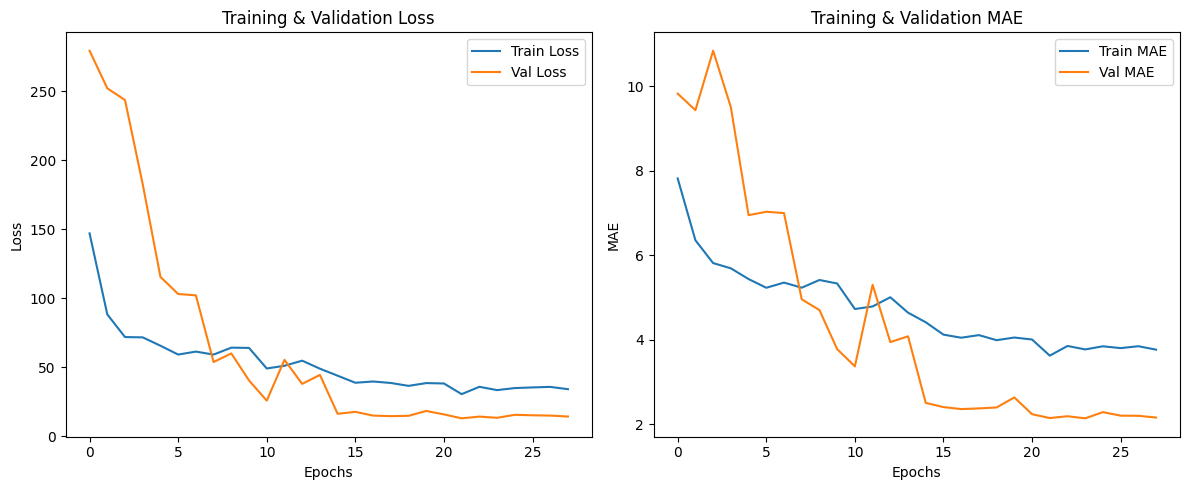

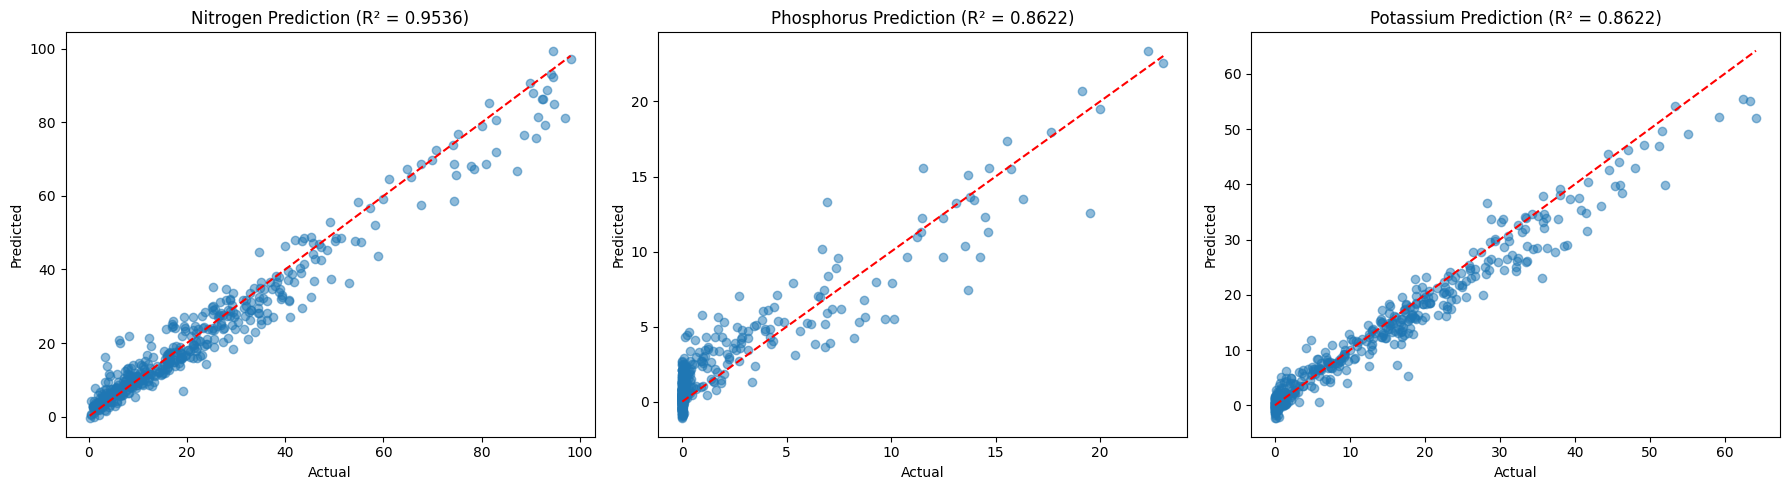


📄 Final metrics saved to: /content/drive/MyDrive/final_combined_model_metrics.csv


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# === Base paths ===
csv_folder = "/content/drive/MyDrive/CSV_Results"
image_base_folder = "/content/drive/MyDrive/Enhanced-cotton-leaf-disease"
model_save_path = "/content/drive/MyDrive/final_combined_model.h5"
summary_metrics_path = "/content/drive/MyDrive/final_combined_model_metrics.csv"

# === Combine all CSVs ===
csv_paths = glob(os.path.join(csv_folder, "*_results.csv"))
all_data = []

for csv_file in csv_paths:
    class_name = os.path.basename(csv_file).replace("_results.csv", "")
    df = pd.read_csv(csv_file)
    df["class"] = class_name
    df["image_path"] = df["img"].apply(lambda x: os.path.join(image_base_folder, class_name, x))
    df = df[df["image_path"].apply(os.path.exists)]  # Filter valid paths
    all_data.append(df)

# === Unified DataFrame ===
full_df = pd.concat(all_data, ignore_index=True)
if full_df.empty:
    raise ValueError("No valid images found across all classes!")

# === Load and preprocess images ===
def preprocess_images(paths, target_size=(128, 128)):
    images = []
    for path in paths:
        try:
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
    return np.array(images)

print(f"📸 Total Images: {len(full_df)}")
X = preprocess_images(full_df["image_path"])
y = full_df[["n_def", "p_def", "k_def"]].values

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Data Augmentation ===
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
datagen.fit(X_train)

# === Build Improved Model ===
def build_model_improved():
    model = Sequential([
        Conv2D(64, (3, 3), kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D((2, 2)),

        Conv2D(512, (3, 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, kernel_regularizer=l2(0.001)),
        LeakyReLU(),
        Dropout(0.5),

        Dense(3, activation='linear')  # Output: N, P, K deficiencies
    ])
    model.compile(optimizer=Adam(learning_rate=0.0003),
                  loss=MeanSquaredError(),
                  metrics=['mae', 'mse'])
    return model

model = build_model_improved()

# === Callbacks ===
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]

# === Train Model ===
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# === Save the model ===
model.save(model_save_path)
print(f"\n✅ Final combined model saved to: {model_save_path}")

# === Predictions and Metrics ===
y_pred = model.predict(X_test)
metrics = {
    "N_R2": r2_score(y_test[:, 0], y_pred[:, 0]),
    "P_R2": r2_score(y_test[:, 1], y_pred[:, 1]),
    "K_R2": r2_score(y_test[:, 2], y_pred[:, 2]),
    "N_MAE": mean_absolute_error(y_test[:, 0], y_pred[:, 0]),
    "P_MAE": mean_absolute_error(y_test[:, 1], y_pred[:, 1]),
    "K_MAE": mean_absolute_error(y_test[:, 2], y_pred[:, 2]),
    "N_MSE": mean_squared_error(y_test[:, 0], y_pred[:, 0]),
    "P_MSE": mean_squared_error(y_test[:, 1], y_pred[:, 1]),
    "K_MSE": mean_squared_error(y_test[:, 2], y_pred[:, 2]),
}
pd.DataFrame([metrics]).to_csv(summary_metrics_path, index=False)

# === Final Evaluation on Test Set ===
final_loss, final_mae, final_mse = model.evaluate(X_test, y_test, verbose=0)
print("\n🧾 Final Evaluation on Test Set:")
print(f"📉 Loss: {final_loss:.4f}")
print(f"📏 MAE : {final_mae:.4f}")
print(f"📐 MSE : {final_mse:.4f}")

# === Plot Loss & MAE ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training & Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# === Plot predictions ===
plt.figure(figsize=(18, 5))
titles = ['Nitrogen', 'Phosphorus', 'Potassium']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    plt.plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{titles[i]} Prediction (R² = {metrics[f'{titles[i][0]}_R2']:.4f})")
plt.tight_layout()
plt.show()

print(f"\n📄 Final metrics saved to: {summary_metrics_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


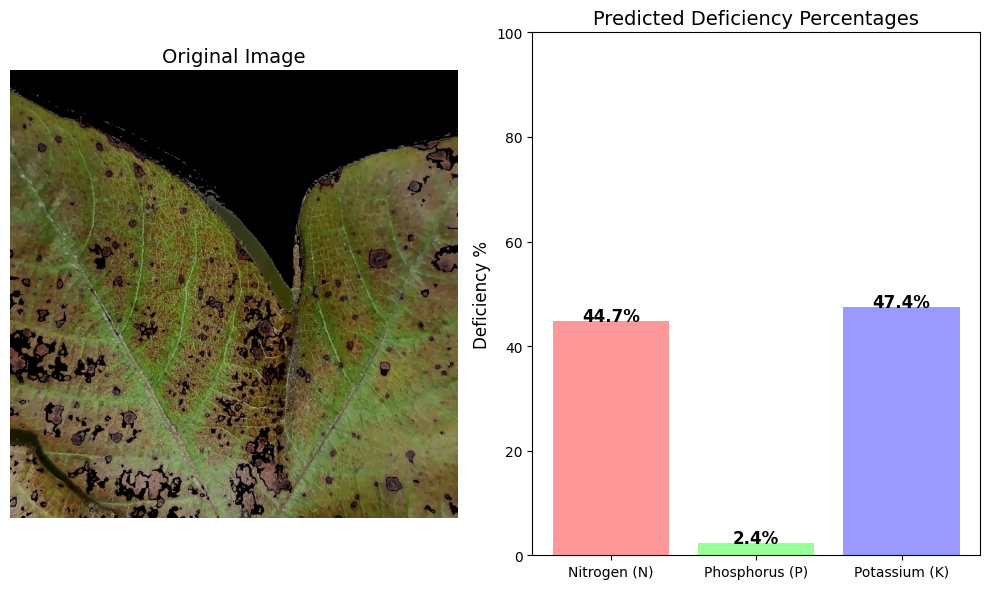

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.gridspec as gridspec
import os

# === Load your final model ===
model_path = "/content/drive/MyDrive/final_combined_model.h5"
model = load_model(model_path)

# === Preprocess single image ===
def preprocess_single_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# === Path to your test image ===
sample_image_path = "LR00566.jpg"

# === Run prediction ===
test_image = preprocess_single_image(sample_image_path)
raw_prediction = model.predict(test_image)[0]

# === Post-process prediction (scale to percentages) ===
prediction = raw_prediction * 100 if np.max(raw_prediction) <= 1 else raw_prediction
prediction = np.clip(prediction, 0, 100)

# === Normalize if total > 100% ===
if prediction.sum() > 100:
    prediction = (prediction / prediction.sum()) * 100

# === Deficiency Info ===
labels = ["Nitrogen (N)", "Phosphorus (P)", "Potassium (K)"]
colors = ['#ff9999', '#99ff99', '#9999ff']

# === Load and show original image ===
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# === Plot results ===
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Original Image
ax_img = fig.add_subplot(gs[0])
ax_img.imshow(original_image)
ax_img.set_title("Original Image", fontsize=14)
ax_img.axis('off')

# Bar Plot of Predictions
ax_bar = fig.add_subplot(gs[1])
bars = ax_bar.bar(labels, prediction, color=colors)
ax_bar.set_ylim(0, 100)
ax_bar.set_ylabel("Deficiency %", fontsize=12)
ax_bar.set_title("Predicted Deficiency Percentages", fontsize=14)

# Add percentage labels on bars
for bar, value in zip(bars, prediction):
    ax_bar.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{value:.1f}%",
                ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
